In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The GP Code

### Covariance Function

RBF Kernel: $k(x_i,x_j) = \sigma^2 exp \left(- \frac{(x_i-x_j)^2}{2 l^2} \right)$

In [2]:
def k_RBF(xi,xj,length_scale,variance):
    return(variance * np.exp(-(xi-xj)**2/(2 * length_scale**2)))

### Covariance Matrix

$\Sigma_{ij} = k(x_i,x_j)$

In [3]:
def Sigma(X,x_t,length_scale,variance):
    X_new = np.append(X,x_t)
    return(np.array([np.array([k_RBF(xi,xj,length_scale,variance) for xj in X_new]) for xi in X_new]))

### Prediction

with $\Sigma = \begin{pmatrix} K & K_* \\ K_*^T & K_{**} \\ \end{pmatrix}$

prediction mean: $\mu_t = K_*^T K^{-1} Y$

prediction variance: $\Sigma_t = K_{**} - K_*^T K^{-1} K_*$

In [4]:
def calc_gp(Sigma,Y):
    K = Sigma[:-1].T[:-1].T
    Kstar = Sigma[-1][:-1]
    Kstarstar = Sigma[-1][-1]
    
    Kinv = np.linalg.inv(K)
    
    mu_t = np.dot(np.dot(Kstar.T,Kinv),Y)
    Sigma_t = Kstarstar - np.dot(np.dot(Kstar.T,Kinv),Kstar)
    
    return np.array([mu_t, Sigma_t])

---

# Generate Data

In [5]:
# help function to generate arrays of predictions
def generate_gp_pts(x_pts,X,Y,length_scale=1,variance=3):
    return np.array([calc_gp(Sigma(X,x,length_scale,variance),Y) for x in x_pts])

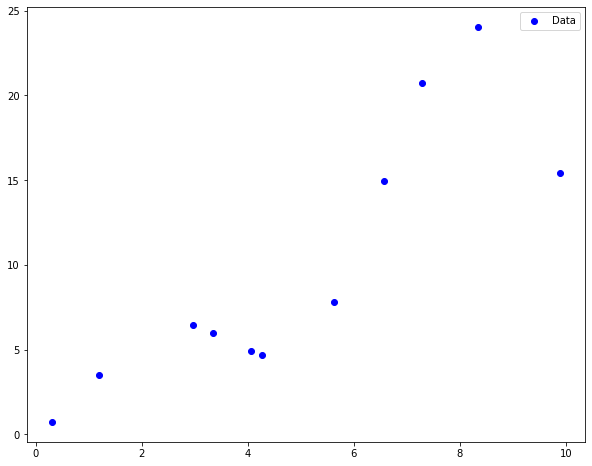

In [6]:
# generate data
x_min, x_max, x_steps = [0,10,11]

X = np.linspace(x_min,x_max,x_steps) + np.random.normal(0,(x_max-x_min)/x_steps,x_steps)
Y = X*np.sin(X) + 2*X

plt.figure(figsize=(10,8))
plt.scatter(X,Y,c="blue",label="Data")
plt.legend()

# Calculate GP

In [7]:
# calculate gp
parameter_l, parameter_var = [1,3]

x_pred = np.arange(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),0.2)
y_pred, y_var = generate_gp_pts(x_pred,X,Y,parameter_l,parameter_var).T

# plotting the actual function for cross check
X_truth = np.linspace(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),100)
Y_truth = X_truth*np.sin(X_truth) + 2*X_truth

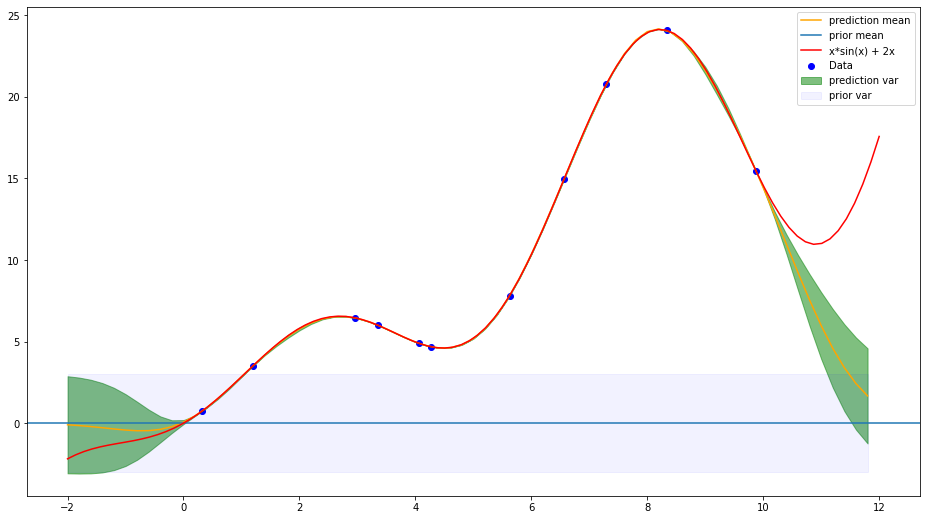

In [8]:
# plot result
plt.figure(figsize=(16,9))

# data
plt.scatter(X,Y,c="blue",label="Data")

# prediction
plt.plot(x_pred,y_pred,c="orange", label="prediction mean")
plt.fill_between(x_pred,
                 y_pred+y_var,
                 y_pred-y_var,
                 color="green",alpha=0.5,label="prediction var")

# prior
plt.axhline(0,label="prior mean")
plt.fill_between([np.min(x_pred),np.max(x_pred)],
                 0+parameter_var,
                 0-parameter_var,
                 color="blue",alpha=0.05,label="prior var")

# true function from which the data was sampled
plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")

plt.legend()
# plt.savefig("gp_figure.png",bbox_inches='tight', pad_inches=0)

In [9]:
# from celluloid import Camera

# %matplotlib notebook

# fig = plt.figure(figsize=(16,9))
# camera = Camera(fig)




# # generate data
# x_min, x_max, x_steps = [0,10,11]

# X = np.linspace(x_min,x_max,x_steps) + np.random.normal(0,(x_max-x_min)/x_steps,x_steps)
# Y = X*np.sin(X) + 2*X

# XY = np.array([X,Y]).T

# np.random.shuffle(XY)

# # calculate gp
# parameter_l, parameter_var = [1,3]

# # plotting the actual function for cross check
# X_truth = np.linspace(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),100)
# Y_truth = X_truth*np.sin(X_truth) + 2*X_truth

# x_pred = np.arange(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),0.2)


# for i in range(len(XY)):
#     y_pred, y_var = generate_gp_pts(x_pred,*XY[:i].T,parameter_l,parameter_var).T



#     # data
#     plt.scatter(*XY[:i].T,c="blue",label="Data")

#     # prediction
#     plt.plot(x_pred,y_pred,c="orange", label="prediction mean")
#     plt.fill_between(x_pred,
#                      y_pred+y_var,
#                      y_pred-y_var,
#                      color="green",alpha=0.5,label="prediction std")

#     # prior
#     plt.axhline(0,label="prior mean")
#     plt.fill_between([np.min(x_pred),np.max(x_pred)],
#                      0+parameter_var,
#                      0-parameter_var,
#                      color="blue",alpha=0.05,label="prior std")

#     camera.snap()

#     # true function from which the data was sampled
#     plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")


# animation = camera.animate(interval=1000)

# # animation.save('Gaussian_Process.mp4')

# Same Thing Using Scikit Learn

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [11]:
gp = GaussianProcessRegressor(kernel=RBF())

# uses fit on the same data as above, defined in X, Y
gp.fit(X.reshape(-1, 1),Y)

# prediction with variance
y_gp_pred, y_gp_pred_var = gp.predict(x_pred.reshape(-1, 1),return_std=True)

print(gp.kernel_)

RBF(length_scale=1.7)


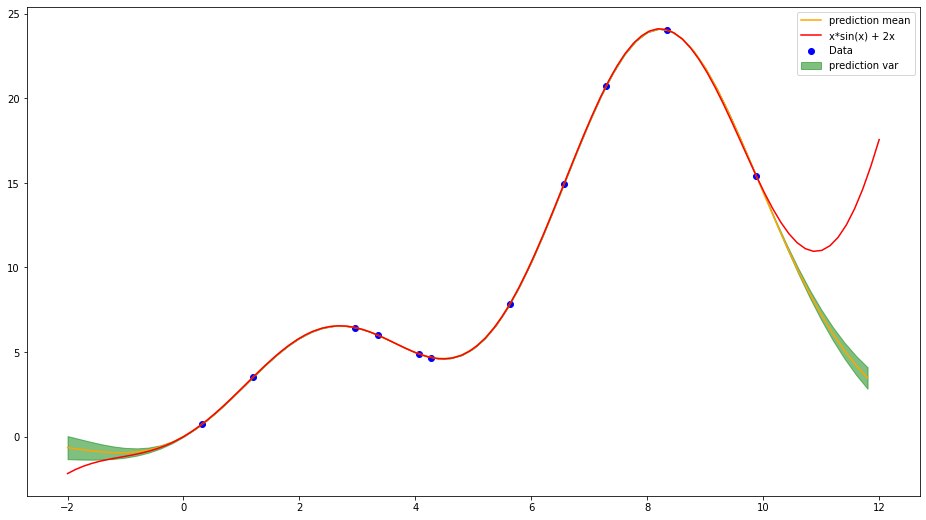

In [12]:
# plot result
plt.figure(figsize=(16,9))

# data
plt.scatter(X,Y,c="blue",label="Data")

# prediction
plt.plot(x_pred,y_gp_pred,c="orange", label="prediction mean")
plt.fill_between(x_pred,
                 y_gp_pred+y_gp_pred_var,
                 y_gp_pred-y_gp_pred_var,
                 color="green",alpha=0.5,label="prediction var")


# true function from which the data was sampled
plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")

plt.legend()
# plt.savefig("gp_figure_sklearn.png",bbox_inches='tight', pad_inches=0)

In [13]:
# from celluloid import Camera

# %matplotlib notebook

# fig = plt.figure(figsize=(16,9))
# camera = Camera(fig)


# # for tries in range(5):

# # generate data
# x_min, x_max, x_steps = [0,10,11]

# X = np.linspace(x_min,x_max,x_steps) + np.random.normal(0,(x_max-x_min)/x_steps,x_steps)
# Y = X*np.sin(X) + 2*X

# XY = np.array([X,Y]).T

# np.random.shuffle(XY)

# gp = GaussianProcessRegressor(kernel=RBF())


# # plotting the actual function for cross check
# X_truth = np.linspace(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),100)
# Y_truth = X_truth*np.sin(X_truth) + 2*X_truth

# x_pred = np.arange(x_min-0.2*np.abs(x_max-x_min),x_max+0.2*np.abs(x_max-x_min),0.2)


# for i in range(1,len(XY)):


#     # uses fit on the same data as above, defined in X, Y
#     gp.fit(XY[:i].T[0].reshape(-1, 1),XY[:i].T[1])

#     # prediction with variance
#     y_gp_pred, y_gp_pred_var = gp.predict(x_pred.reshape(-1, 1),return_std=True)

#     # data
#     plt.scatter(*XY[:i].T,c="blue",label="Data")

#     # prediction
#     plt.plot(x_pred,y_gp_pred,c="orange", label="prediction mean")
#     plt.fill_between(x_pred,
#                      y_gp_pred+y_gp_pred_var,
#                      y_gp_pred-y_gp_pred_var,
#                      color="green",alpha=0.5,label="prediction var")

#     # prior
#     plt.axhline(0,label="prior mean")
#     plt.fill_between([np.min(x_pred),np.max(x_pred)],
#                      0+parameter_var,
#                      0-parameter_var,
#                      color="blue",alpha=0.05,label="prior var")

    

#     # true function from which the data was sampled
#     plt.plot(X_truth,Y_truth,c="red",label="x*sin(x) + 2x")
#     camera.snap()


# animation = camera.animate(interval=1000)
# # animation.save('Gaussian_Process_sklearn.mp4')